### Cross Frequency Coupling

In this notebook, I will calculate the phase-amplitude coupling using Tort method. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.signaltools import SignalToolkit
import ipywidgets as widgets
my_layout = widgets.Layout()
import typing
from typing import List
import seaborn as sns

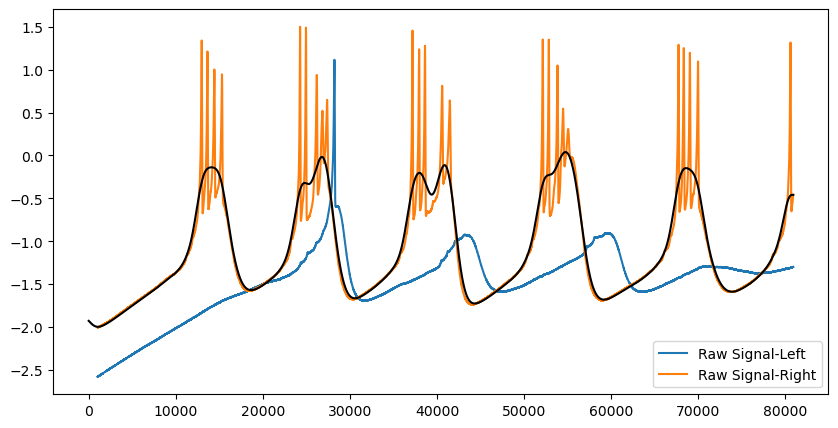

In [10]:
# read data
from cProfile import label


filename = '/home/yat-lok/workspace/data4project/lateralization/LFP_critical/SNC/4073A_0.01.csv'
df = pd.read_csv(filename)
df_left = df.iloc[1024:,5]
df_right = df.iloc[1024:,6]

df_left_low = SignalToolkit.hamming_filter(df_left, [2,8], 81920)
df_left_high = SignalToolkit.sos_filter(df_left, [20,45], 81920)
df_right_low = SignalToolkit.hamming_filter(df_right, [2,8], 81920)
df_right_high = SignalToolkit.sos_filter(df_right, [20,45], 81920)


# # visualize results
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(np.arange(1024, 81920-1024, 1) ,df_left[1024:], label = "Raw Signal-Left")
axes.plot(np.arange(1024, 81920-1024, 1) ,df_right[1024:], label = "Raw Signal-Right")
#axes.plot(df_left_low, c='black', label="Gamma Frequency")
axes.plot(df_right_low, c='black')
plt.legend()


/home/yat-lok/miniconda3/envs/tvbenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yat-lok/miniconda3/envs/tvbenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan


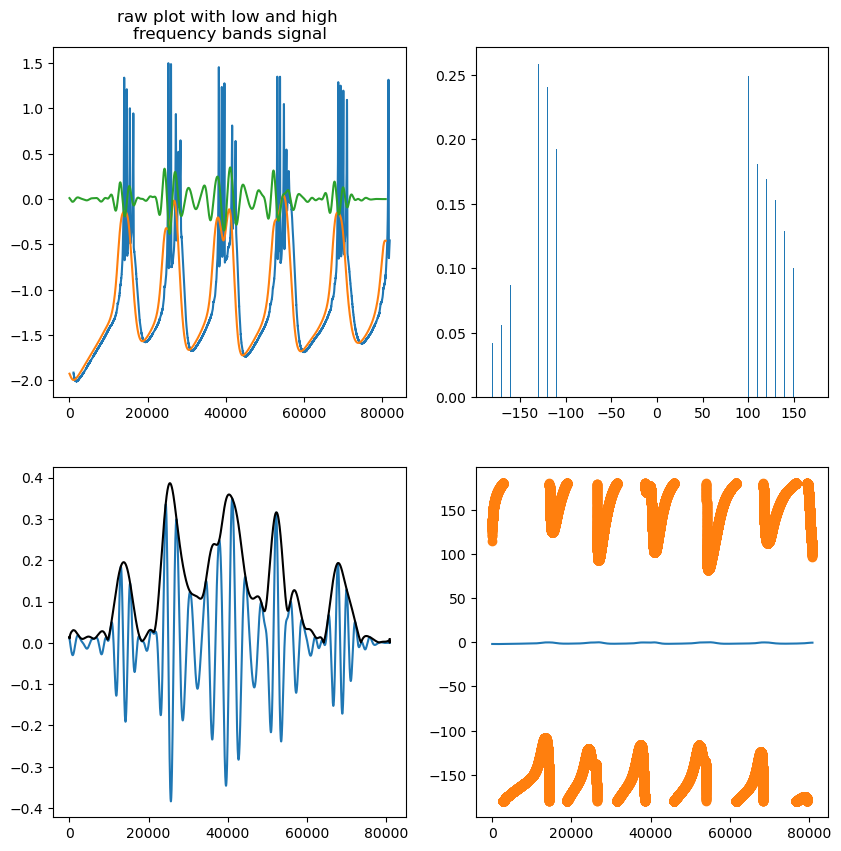

In [3]:
# %matplotlib widget
# hilbert transform
# step 1, get the amplitude envelop of high freq
akey = "df_right"
if akey == "df_left":
    key = df_left
    key_high = df_left_high
    key_low = df_left_low
else:
    key = df_right
    key_high = df_right_high
    key_low = df_right_low

h1=signal.hilbert(key_high)
amplitude_envelope = np.abs(h1)

# step 2, get the phase information of low freq
l1 = signal.hilbert(key_low)
phase_y1=np.degrees(np.angle(l1))

# step 3 bin the phase
bins = 36
cycle = 360/bins
stamp = np.arange(-180, 180, cycle)
phase_amp = np.zeros(len(stamp)) 
for ind, i in enumerate(stamp):
    phase_range = np.logical_and(phase_y1 >= i,
                                        phase_y1 < (i + cycle))
    amp_value = amplitude_envelope[phase_range]
    phase_amp[ind] = np.mean(amp_value)
# step 4, entropy method H
p_j = [p_j_single/np.sum(phase_amp) for p_j_single in phase_amp]
cap_H = -np.sum(p_j * np.log(p_j))

# step 5, calculate the MI
MI = (np.log(len(stamp))-cap_H) / np.log(len(stamp))
print(MI)

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(222)
axes.bar(stamp, phase_amp)
# graph 2
axes2 = fig.add_subplot(221)
axes2.set_title("raw plot with low and high \nfrequency bands signal")
axes2.plot(key)
axes2.plot(key_low)
axes2.plot(key_high)

axes3 = fig.add_subplot(223)
axes3.plot(key_high)
axes3.plot(amplitude_envelope, color = "black")

axes4 = fig.add_subplot(224)
axes4.plot(key_low)
axes4.plot(phase_y1, "o")
plt.show()